In [1]:
# help me to data preprocess and import necessary libraries for image classification problem

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_path = 'train/'
test_path = 'test/'
val_path = 'val/'

In [3]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Battery: 756
Biological: 788
Cardboard: 1000
Clothes: 1000
Glass: 1000
Metal: 1000
Paper: 1000
Plastic: 1000
Shoes: 1000
Trash: 667

Total number of train images: 9211


In [4]:
total = 0
for category in os.listdir(test_path):
    count= 0
    for image in os.listdir(test_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of test images: {total}")

Battery: 95
Biological: 99
Cardboard: 234
Clothes: 533
Glass: 409
Metal: 188
Paper: 272
Plastic: 253
Shoes: 199
Trash: 84

Total number of test images: 2366


In [5]:
total = 0
for category in os.listdir(val_path):
    count= 0
    for image in os.listdir(val_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of val images: {total}")

Battery: 94
Biological: 98
Cardboard: 233
Clothes: 532
Glass: 409
Metal: 186
Paper: 271
Plastic: 251
Shoes: 197
Trash: 83

Total number of val images: 2354


In [6]:
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

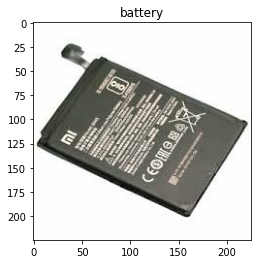

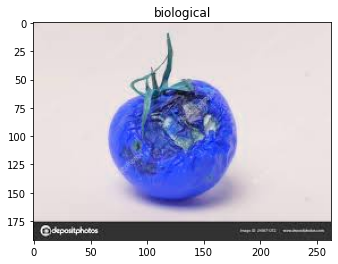

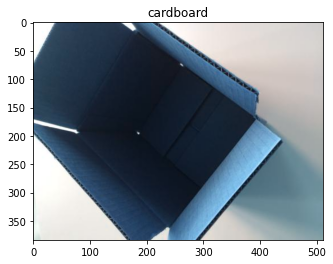

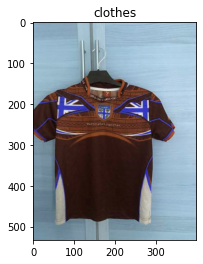

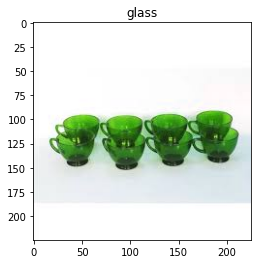

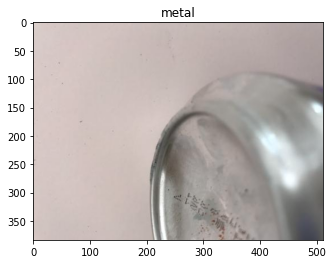

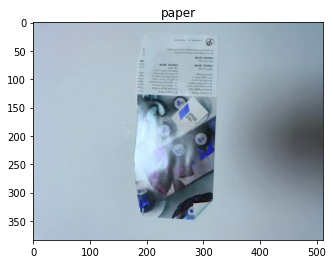

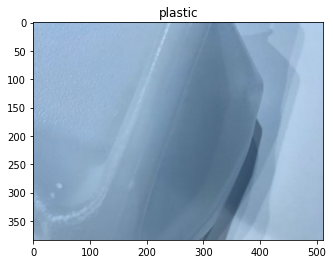

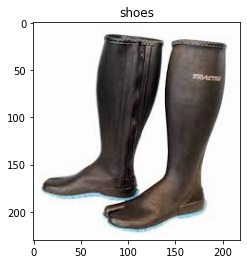

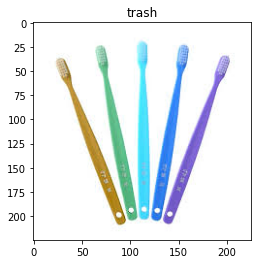

In [7]:
for category in class_names:
    img = cv2.imread(train_path + category + "/" + os.listdir(train_path + category)[1])
    plt.imshow(img)
    plt.title(category)
    plt.show()

In [8]:
import os
import cv2
import numpy as np

def load_and_preprocess_data(path):
    X = []
    y = []
    for category in os.listdir(path):
        for image in os.listdir(os.path.join(path, category)):
            img_path = os.path.join(path, category, image)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))
                X.append(img)
                y.append(category)
            else:
                print(f"Failed to load image: {img_path}")
    X = np.array(X) / 255.0  # normalize pixel values
    y = np.array(y)
    return X, y

X_train, y_train = load_and_preprocess_data(train_path)
X_test, y_test = load_and_preprocess_data(test_path)
X_val, y_val = load_and_preprocess_data(val_path)

In [9]:
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)
print("X val shape: ", X_val.shape)
print("y val shape: ", y_val.shape)

X train shape:  (9211, 64, 64, 3)
y train shape:  (9211,)
X test shape:  (2366, 64, 64, 3)
y test shape:  (2366,)
X val shape:  (2354, 64, 64, 3)
y val shape:  (2354,)


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                802880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [32]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

onehot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = y_train_encoded.reshape(len(y_train_encoded), 1)
y_train_encoded = onehot_encoder.fit_transform(y_train_encoded)

y_test_encoded = label_encoder.transform(y_test)
y_test_encoded = y_test_encoded.reshape(len(y_test_encoded), 1)
y_test_encoded = onehot_encoder.transform(y_test_encoded)

y_val_encoded = label_encoder.transform(y_val)
y_val_encoded = y_val_encoded.reshape(len(y_val_encoded), 1)
y_val_encoded = onehot_encoder.transform(y_val_encoded)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_history = model.fit(datagen.flow(X_train, y_train_encoded), validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stopping])

Epoch 1/100
288/288 [==============================] - 10s 34ms/step - loss: 1.4310 - accuracy: 0.5102 - val_loss: 1.2968 - val_accuracy: 0.5663
Epoch 2/100
288/288 [==============================] - 9s 32ms/step - loss: 1.4145 - accuracy: 0.5126 - val_loss: 1.1995 - val_accuracy: 0.5918
Epoch 3/100
288/288 [==============================] - 9s 32ms/step - loss: 1.3997 - accuracy: 0.5234 - val_loss: 1.1336 - val_accuracy: 0.6287
Epoch 4/100
288/288 [==============================] - 9s 30ms/step - loss: 1.3861 - accuracy: 0.5244 - val_loss: 1.3410 - val_accuracy: 0.5586
Epoch 5/100
288/288 [==============================] - 9s 31ms/step - loss: 1.3816 - accuracy: 0.5297 - val_loss: 1.1693 - val_accuracy: 0.6262
Epoch 6/100
288/288 [==============================] - 9s 32ms/step - loss: 1.3716 - accuracy: 0.5397 - val_loss: 1.1141 - val_accuracy: 0.6249
Epoch 7/100
288/288 [==============================] - 9s 30ms/step - loss: 1.3649 - accuracy: 0.5407 - val_loss: 1.2025 - val_accuracy

In [22]:
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# # Create a label (category) encoder object
# le = LabelEncoder()

# # Fit and transform the label encoder
# y_train_int = le.fit_transform(y_train)
# y_val_int = le.transform(y_val)

# # Now convert the integer labels to one-hot encoding
# y_train_encoded = to_categorical(y_train_int)
# y_val_encoded = to_categorical(y_val_int)

# model_history = model.fit(X_train, y_train_encoded, epochs=40, validation_data=(X_val, y_val_encoded))
# # model_history = model.fit(X_train, y_train_encoded, epochs=100, 
#         #   validation_data=(X_val, y_val_encoded))

Epoch 1/40
288/288 [==============================] - 3s 12ms/step - loss: 0.3528 - accuracy: 0.8646 - val_loss: 1.9302 - val_accuracy: 0.7285
Epoch 2/40
288/288 [==============================] - 3s 11ms/step - loss: 0.3661 - accuracy: 0.8548 - val_loss: 1.7356 - val_accuracy: 0.7179
Epoch 3/40
288/288 [==============================] - 3s 11ms/step - loss: 0.3396 - accuracy: 0.8679 - val_loss: 1.8005 - val_accuracy: 0.7137
Epoch 4/40
288/288 [==============================] - 3s 11ms/step - loss: 0.3647 - accuracy: 0.8620 - val_loss: 1.7402 - val_accuracy: 0.7150
Epoch 5/40
288/288 [==============================] - 3s 11ms/step - loss: 0.3509 - accuracy: 0.8631 - val_loss: 1.8955 - val_accuracy: 0.7145
Epoch 6/40
288/288 [==============================] - 3s 10ms/step - loss: 0.3570 - accuracy: 0.8614 - val_loss: 1.8429 - val_accuracy: 0.7065
Epoch 7/40
288/288 [==============================] - 3s 10ms/step - loss: 0.3488 - accuracy: 0.8653 - val_loss: 1.9044 - val_accuracy: 0.7120

Epoch 50/50
288/288 [==============================] - 2s 9ms/step - loss: 1.1019 - accuracy: 0.6095 - val_loss: 1.1645 - val_accuracy: 0.6096

---
2nd - 
Epoch 50/50
288/288 [==============================] - 4s 15ms/step - loss: 0.3476 - accuracy: 0.8727 - val_loss: 2.9125 - val_accuracy: 0.5926

In [64]:
from tensorflow.keras.utils import to_categorical
y_test_int = label_encoder.transform(y_test)
y_test_encoded = to_categorical(y_test_int)

model.evaluate(X_test, y_test_encoded)

74/74 [==============================] - 0s 4ms/step - loss: 1.1117 - accuracy: 0.6014


[1.1117002964019775, 0.6014370322227478]

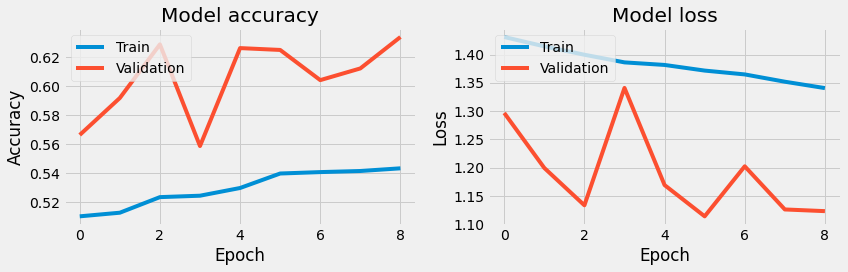

In [65]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Actual category: shoes
Predicted category: shoes


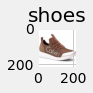

Actual category: battery
Predicted category: metal


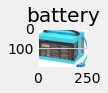

Actual category: metal
Predicted category: clothes


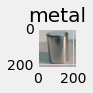

Actual category: glass
Predicted category: glass


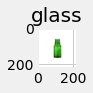

Actual category: trash
Predicted category: trash


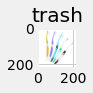

Actual category: battery
Predicted category: battery


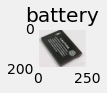

Actual category: battery
Predicted category: battery


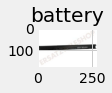

Actual category: metal
Predicted category: plastic


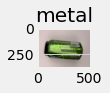

Actual category: clothes
Predicted category: plastic


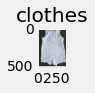

Actual category: metal
Predicted category: metal


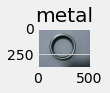

Actual category: plastic
Predicted category: metal


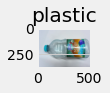

Actual category: metal
Predicted category: plastic


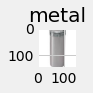

Actual category: clothes
Predicted category: clothes


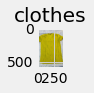

Actual category: trash
Predicted category: paper


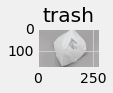

Actual category: battery
Predicted category: glass


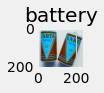

<Figure size 432x288 with 0 Axes>

In [68]:
import random
from tensorflow.keras.preprocessing import image

def predict_random_image(path):
    category = random.choice(os.listdir(path))
    img_path = random.choice(os.listdir(os.path.join(path, category)))
    img_path = os.path.join(path, category, img_path)
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    prediction = np.argmax(prediction, axis=1)
    print(f"Actual category: {category}")
    print(f"Predicted category: {class_names[prediction[0]]}")
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(category)
    plt.show()

# Predict and display random images
for i in range(15):
    plt.subplot(5, 3, i+1)
    predict_random_image(test_path)
plt.tight_layout()
plt.show()

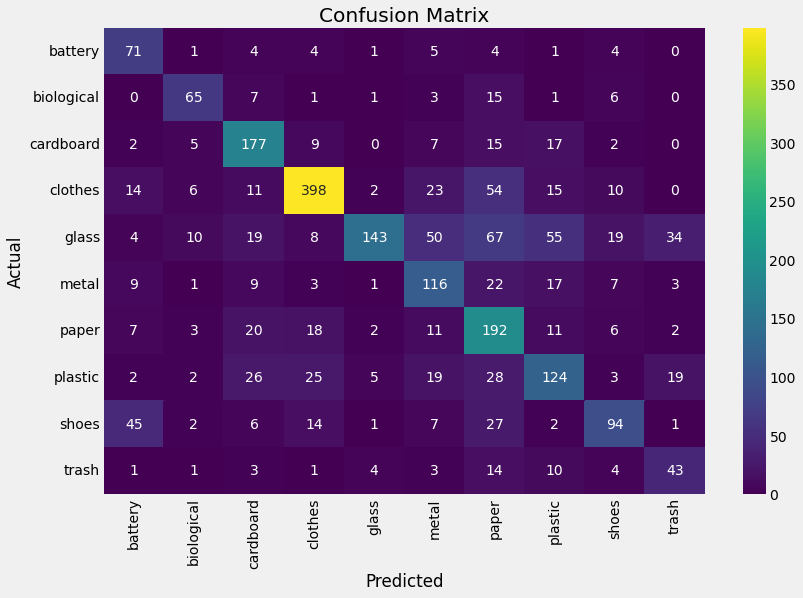

In [71]:
# which category is the most difficult to predict?
import seaborn as sns
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_int = label_encoder.transform(y_test)
y_test_encoded = to_categorical(y_test_int)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_int, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [72]:
confusion_matrix_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_matrix_df

,battery,biological,cardboard,clothes,glass,metal,paper,plastic,shoes,trash
battery,71,1,4,4,1,5,4,1,4,0
biological,0,65,7,1,1,3,15,1,6,0
cardboard,2,5,177,9,0,7,15,17,2,0
clothes,14,6,11,398,2,23,54,15,10,0
glass,4,10,19,8,143,50,67,55,19,34
metal,9,1,9,3,1,116,22,17,7,3
paper,7,3,20,18,2,11,192,11,6,2
plastic,2,2,26,25,5,19,28,124,3,19
shoes,45,2,6,14,1,7,27,2,94,1
trash,1,1,3,1,4,3,14,10,4,43
